In [1]:
%load_ext autoreload
%autoreload 2
import theano
import theano.tensor as T
import numpy as np
import FSRCNN_VGG
import os
import preprocessing_VGG
from scipy import ndimage,misc
import FSRCNN_Theano

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
/home/ubuntu/miniconda2/envs/theano/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
#Create Validation_Subsamples_RGB_4 and Validation_Subsamples_RGB_4_GT folders
#preprocessing.create_subimages('/home/jon/Documents/Neural_Networks/project/SRCNN_Theano/Data/Set5',
#'/home/jon/Documents/Neural_Networks/project/SRCNN_Theano/Data/Validation_Subsamples_RGB_4',
#output_type ='RGB',upsampling_factor = 4)

#preprocessing.create_subimages('/home/jon/Documents/Neural_Networks/project/SRCNN_Theano/Data/Set14',
#'/home/jon/Documents/Neural_Networks/project/SRCNN_Theano/Data/Test_Subsamples_RGB_4',
#output_type ='RGB',upsampling_factor = 4)

#preprocessing.create_subimages('/home/jon/Documents/Neural_Networks/project/SRCNN_Theano/Data/Training_Full',
#'/home/jon/Documents/Neural_Networks/project/SRCNN_Theano/Data/Training_Subsamples_RGB_4',
#output_type ='RGB',upsampling_factor = 4)

In [2]:
#load dataset

#load training
data_x = FSRCNN_Theano.load_dataset('/home/ubuntu/Data/Training_Subsamples_RGB_4','data_x')
data_y = FSRCNN_Theano.load_dataset('/home/ubuntu/Data/Training_Subsamples_RGB_4_gt','data_y')
print "done loading\n\n"
print "data_x: " + str(data_x.shape)
print "data_y: " + str(data_y.shape)

/home/ubuntu/Data/Training_Subsamples_RGB_4
loading from npz
/home/ubuntu/Data/Training_Subsamples_RGB_4_gt
loading from npz
done loading


data_x: (22092, 3, 8, 8)
data_y: (22092, 3, 33, 33)


In [3]:
valid_x = FSRCNN_Theano.load_dataset('/home/ubuntu/Data/Validation_Subsamples_RGB_4','data_x')
valid_y = FSRCNN_Theano.load_dataset('/home/ubuntu/Data/Validation_Subsamples_RGB_4_gt','data_y')
print "valid_x: " + str(valid_x.shape)
print "valid_y: " + str(valid_y.shape)

/home/ubuntu/Data/Validation_Subsamples_RGB_4
loading from npz
/home/ubuntu/Data/Validation_Subsamples_RGB_4_gt
loading from npz
valid_x: (2488, 3, 8, 8)
valid_y: (2488, 3, 33, 33)


In [4]:
test_x = FSRCNN_Theano.load_dataset('/home/ubuntu/Data/Test_Subsamples_RGB_4','data_x')
test_y = FSRCNN_Theano.load_dataset('/home/ubuntu/Data/Test_Subsamples_RGB_4_gt','data_y')
print "test_x: " + str(test_x.shape)
print "test_y: " + str(test_y.shape)

/home/ubuntu/Data/Test_Subsamples_RGB_4
loading from npz
/home/ubuntu/Data/Test_Subsamples_RGB_4_gt
loading from npz
test_x: (14851, 3, 8, 8)
test_y: (14851, 3, 33, 33)


In [5]:
#Bicubic interp to save computation during training
upsampled_x = data_x#preprocessing_VGG.upsample(data_x) #33,33,3 input images expected
up_val_x = valid_x#preprocessing_VGG.upsample(valid_x) #33,33,3 input images expected
up_test_x = test_x #preprocessing_VGG.upsample(test_x) #33,33,3 input images expected

#Reshape for training,valid,test
upsampled_x = upsampled_x.reshape((22092,8*8*3))
data_y = data_y.reshape((22092,33*33*3))
up_val_x = up_val_x.reshape((2488,8*8*3))
valid_y = valid_y.reshape((2488,33*33*3))
up_test_x = up_test_x.reshape((14851,8*8*3))
test_y = test_y.reshape((14851,33*33*3))

print upsampled_x.shape
print data_y.shape
print up_val_x.shape
print up_test_x.shape

(22092, 192)
(22092, 3267)
(2488, 192)
(14851, 192)


In [6]:
shared_x = theano.shared(np.asarray(upsampled_x,
                                       dtype=theano.config.floatX),
                         borrow=True)
shared_y = theano.shared(np.asarray(data_y,
                                       dtype=theano.config.floatX),
                         borrow=True)
shared_val_x = theano.shared(np.asarray(up_val_x,
                                       dtype=theano.config.floatX),
                         borrow=True)
shared_val_y = theano.shared(np.asarray(valid_y,
                                       dtype=theano.config.floatX),
                         borrow=True)
shared_test_x = theano.shared(np.asarray(up_test_x,
                                       dtype=theano.config.floatX),
                         borrow=True)
shared_test_y = theano.shared(np.asarray(test_y,
                                       dtype=theano.config.floatX),
                         borrow=True)

In [41]:
batch_size = 25
n_epochs = 20
#lrs = [.1,.07,.05,.03,.007,.005,.002,.0009,.0007,.0004,.0001]
lrs = [.0001]
for lr in lrs:
    print "\n\n ****************************** lr = " + str(lr) +"******************************************"
    learning_rate = lr

    n_train_batches = upsampled_x.shape[0]/batch_size
    n_valid_batches = up_val_x.shape[0]/batch_size
    n_test_batches = up_test_x.shape[0]/batch_size


    val_model,test_model = FSRCNN_VGG.train_FSRCNN_VGG(shared_x,shared_y,
                             shared_val_x,shared_val_y,
                             shared_test_x,shared_test_y,
                            n_train_batches, n_valid_batches, n_test_batches, 
                             n_epochs, batch_size,learning_rate,upsampling_factor=4)




 ****************************** lr = 0.0001******************************************
theano optimizer: fast_compile
lovely....

filter_shape...: (64, 3, 9, 9)
image_shape...: (25, 3, 8, 8)
input shape....: Shape.0
lovely....

filter_shape...: (32, 64, 5, 5)
image_shape...: (25, 64, 8, 8)
input shape....: Shape.0
decon layer....

filter_shape...: (3, 32, 14, 14)
image_shape...: (25, 32, 8, 8)
input shape....: Shape.0
... building the vgg model for low resolution input
('im_dims=', array([21, 21]))
('Loading weights for Layer: ', 1)
('Weights loaded with dims: ', (64, 3, 3, 3), 'and', (64,))
('Loading weights for Layer: ', 2)
('Weights loaded with dims: ', (64, 64, 3, 3), 'and', (64,))
('Loading weights for Layer: ', 3)
('Weights loaded with dims: ', (128, 64, 3, 3), 'and', (128,))
('Loading weights for Layer: ', 4)
('Weights loaded with dims: ', (128, 128, 3, 3), 'and', (128,))
... building the vgg model for high resolution input
('im_dims=', array([33, 33]))
('Loading weights for La

VGG LOSS + MSE PER PIXEL

In [ ]:
batch_size = 25
n_epochs = 20
#lrs = [.1,.07,.05,.03,.007,.005,.002,.0009,.0007,.0004,.0001]
lrs = [.0001]
for lr in lrs:
    print "\n\n ****************************** lr = " + str(lr) +"******************************************"
    learning_rate = lr

    n_train_batches = upsampled_x.shape[0]/batch_size
    n_valid_batches = up_val_x.shape[0]/batch_size
    n_test_batches = up_test_x.shape[0]/batch_size


    val_model,test_model = FSRCNN_VGG.train_FSRCNN_VGG(shared_x,shared_y,
                             shared_val_x,shared_val_y,
                             shared_test_x,shared_test_y,
                            n_train_batches, n_valid_batches, n_test_batches, 
                             n_epochs, batch_size,learning_rate,upsampling_factor=4)

In [47]:
import FSRCNN_Theano
reconstructed_imgs = np.zeros((14851, 3, 21, 21))
for i in xrange(n_test_batches):
     cost,MSE_per_pixel,psnr,reconstucted_patches = test_model(i)
     reconstructed_imgs[i*batch_size:(i+1)*batch_size,:,:,:] = reconstucted_patches

FSRCNN_Theano.rebuild_images(reconstructed_imgs,'/home/ubuntu/Data/Test_Subsamples_RGB_4',patch_dim=21,dataset='test_VGG_FRCNN')
FSRCNN_Theano.rebuild_images(reconstructed_imgs,'/home/ubuntu/Data/Test_Subsamples_RGB_4',patch_dim=21,dataset='test_VGG_FRCNN', place=True)        

(480, 500, '\n')
(32, 34, '\n')
(576, 720, '\n')
(39, 50, '\n')
(512, 512, '\n')
(35, 35, '\n')
(288, 352, '\n')
(19, 23, '\n')
(361, 250, '\n')
(24, 16, '\n')
(276, 276, '\n')
(18, 18, '\n')
(362, 500, '\n')
(24, 34, '\n')
(288, 352, '\n')
(19, 23, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 768, '\n')
(35, 53, '\n')
(512, 512, '\n')
(35, 35, '\n')
(656, 529, '\n')
(45, 36, '\n')
(391, 586, '\n')
(26, 40, '\n')
(480, 500, '\n')
(32, 34, '\n')
(576, 720, '\n')
(39, 50, '\n')
(512, 512, '\n')
(35, 35, '\n')
(288, 352, '\n')
(19, 23, '\n')
(361, 250, '\n')
(24, 16, '\n')
(276, 276, '\n')
(18, 18, '\n')
(362, 500, '\n')
(24, 34, '\n')
(288, 352, '\n')
(19, 23, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 768, '\n')
(35, 53, '\n')
(512, 512, '\n')
(35, 35, '\n')
(656, 529, '\n')
(45, 36, '\n')
(391, 586, '\n')
(26, 40, '\n')


In [43]:
display_img_path = '/home/ubuntu/e4040_project_ahj1/FSRCNN_Experiments_Newer_Version/recon_imgs_test_VGG_FRCNN/baboon.bmp'

In [44]:
cmd = os.environ.get('SCIPY_PIL_IMAGE_VIEWER', 'see')

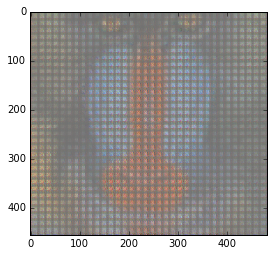

In [45]:
from PIL import Image
imgx = (Image.open(display_img_path))
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(imgx)

In [60]:
#with input to VGG just the center pixels 21x21 

batch_size = 50
n_epochs = 25
#lrs = [.1,.07,.05,.03,.007,.005,.002,.0009,.0007,.0004,.0001]
lrs = [.0005]
for lr in lrs:
    print "\n\n ****************************** lr = " + str(lr) +"******************************************"
    learning_rate = lr

    n_train_batches = upsampled_x.shape[0]/batch_size
    n_valid_batches = up_val_x.shape[0]/batch_size
    n_test_batches = up_test_x.shape[0]/batch_size


    val_model,test_model = FSRCNN_VGG.train_FSRCNN_VGG(shared_x,shared_y,
                             shared_val_x,shared_val_y,
                             shared_test_x,shared_test_y,
                            n_train_batches, n_valid_batches, n_test_batches, 
                             n_epochs, batch_size,learning_rate,upsampling_factor=4)




 ****************************** lr = 0.0005******************************************
theano optimizer: fast_compile
lovely....

filter_shape...: (64, 3, 9, 9)
image_shape...: (50, 3, 8, 8)
input shape....: Shape.0
lovely....

filter_shape...: (32, 64, 5, 5)
image_shape...: (50, 64, 8, 8)
input shape....: Shape.0
decon layer....

filter_shape...: (3, 32, 9, 9)
image_shape...: (50, 32, 8, 8)
input shape....: Shape.0
... building the vgg model for low resolution input
('im_dims=', array([16, 16]))
('Loading weights for Layer: ', 1)
('Weights loaded with dims: ', (64, 3, 3, 3), 'and', (64,))
('Loading weights for Layer: ', 2)
('Weights loaded with dims: ', (64, 64, 3, 3), 'and', (64,))
('Loading weights for Layer: ', 3)
('Weights loaded with dims: ', (128, 64, 3, 3), 'and', (128,))
('Loading weights for Layer: ', 4)
('Weights loaded with dims: ', (128, 128, 3, 3), 'and', (128,))
... building the vgg model for high resolution input
('im_dims=', array([33, 33]))
('Loading weights for Laye

In [59]:
import FSRCNN_Theano
reconstructed_imgs = np.zeros((14851, 3, 16, 16))
for i in xrange(n_test_batches):
     cost,MSE_per_pixel,psnr,reconstucted_patches = test_model(i)
     reconstructed_imgs[i*batch_size:(i+1)*batch_size,:,:,:] = reconstucted_patches

FSRCNN_Theano.rebuild_images(reconstructed_imgs,'/home/ubuntu/Data/Test_Subsamples_RGB_4',patch_dim=16,dataset='test_VGG_FRCNN_Both_Losses')
FSRCNN_Theano.rebuild_images(reconstructed_imgs,'/home/ubuntu/Data/Test_Subsamples_RGB_4',patch_dim=16,dataset='test_VGG_FRCNN_Both_Losses', place=True)        

(480, 500, '\n')
(32, 34, '\n')
(576, 720, '\n')
(39, 50, '\n')
(512, 512, '\n')
(35, 35, '\n')
(288, 352, '\n')
(19, 23, '\n')
(361, 250, '\n')
(24, 16, '\n')
(276, 276, '\n')
(18, 18, '\n')
(362, 500, '\n')
(24, 34, '\n')
(288, 352, '\n')
(19, 23, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 768, '\n')
(35, 53, '\n')
(512, 512, '\n')
(35, 35, '\n')
(656, 529, '\n')
(45, 36, '\n')
(391, 586, '\n')
(26, 40, '\n')
(480, 500, '\n')
(32, 34, '\n')
(576, 720, '\n')
(39, 50, '\n')
(512, 512, '\n')
(35, 35, '\n')
(288, 352, '\n')
(19, 23, '\n')
(361, 250, '\n')
(24, 16, '\n')
(276, 276, '\n')
(18, 18, '\n')
(362, 500, '\n')
(24, 34, '\n')
(288, 352, '\n')
(19, 23, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 768, '\n')
(35, 53, '\n')
(512, 512, '\n')
(35, 35, '\n')
(656, 529, '\n')
(45, 36, '\n')
(391, 586, '\n')
(26, 40, '\n')


In [ ]:
from PIL import Image
imgx = (Image.open(display_img_path))
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(imgx)

Different learning rate and epochs and batch size

In [10]:
#with input to VGG just the center pixels 21x21 

batch_size = 50
n_epochs = 25
#lrs = [.1,.07,.05,.03,.007,.005,.002,.0009,.0007,.0004,.0001]
lrs = [.0001]
for lr in lrs:
    print "\n\n ****************************** lr = " + str(lr) +"******************************************"
    learning_rate = lr

    n_train_batches = upsampled_x.shape[0]/batch_size
    n_valid_batches = up_val_x.shape[0]/batch_size
    n_test_batches = up_test_x.shape[0]/batch_size


    val_model,test_model = FSRCNN_VGG.train_FSRCNN_VGG(shared_x,shared_y,
                             shared_val_x,shared_val_y,
                             shared_test_x,shared_test_y,
                            n_train_batches, n_valid_batches, n_test_batches, 
                             n_epochs, batch_size,learning_rate,upsampling_factor=4)





 ****************************** lr = 0.0001******************************************
theano optimizer: fast_compile
lovely....

filter_shape...: (64, 3, 9, 9)
image_shape...: (50, 3, 8, 8)
input shape....: Shape.0
lovely....

filter_shape...: (32, 64, 5, 5)
image_shape...: (50, 64, 8, 8)
input shape....: Shape.0
decon layer....

filter_shape...: (3, 32, 9, 9)
image_shape...: (50, 32, 8, 8)
input shape....: Shape.0
... building the vgg model for low resolution input
('im_dims=', array([16, 16]))
('Loading weights for Layer: ', 1)
('Weights loaded with dims: ', (64, 3, 3, 3), 'and', (64,))
('Loading weights for Layer: ', 2)
('Weights loaded with dims: ', (64, 64, 3, 3), 'and', (64,))
('Loading weights for Layer: ', 3)
('Weights loaded with dims: ', (128, 64, 3, 3), 'and', (128,))
('Loading weights for Layer: ', 4)
('Weights loaded with dims: ', (128, 128, 3, 3), 'and', (128,))
... building the vgg model for high resolution input
('im_dims=', array([33, 33]))
('Loading weights for Laye

In [11]:
import FSRCNN_Theano
reconstructed_imgs = np.zeros((14851, 3, 16, 16))
for i in xrange(n_test_batches):
     cost,MSE_per_pixel,psnr,reconstucted_patches = test_model(i)
     reconstructed_imgs[i*batch_size:(i+1)*batch_size,:,:,:] = reconstucted_patches

FSRCNN_Theano.rebuild_images(reconstructed_imgs,'/home/ubuntu/Data/Test_Subsamples_RGB_4',patch_dim=16,dataset='test_VGG_FRCNN_Both_Losses_MoreEpochs')
FSRCNN_Theano.rebuild_images(reconstructed_imgs,'/home/ubuntu/Data/Test_Subsamples_RGB_4',patch_dim=16,dataset='test_VGG_FRCNN_Both_Losses_MoreEpochs', place=True)        

(480, 500, '\n')
(32, 34, '\n')
(576, 720, '\n')
(39, 50, '\n')
(512, 512, '\n')
(35, 35, '\n')
(288, 352, '\n')
(19, 23, '\n')
(361, 250, '\n')
(24, 16, '\n')
(276, 276, '\n')
(18, 18, '\n')
(362, 500, '\n')
(24, 34, '\n')
(288, 352, '\n')
(19, 23, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 768, '\n')
(35, 53, '\n')
(512, 512, '\n')
(35, 35, '\n')
(656, 529, '\n')
(45, 36, '\n')
(391, 586, '\n')
(26, 40, '\n')
(480, 500, '\n')
(32, 34, '\n')
(576, 720, '\n')
(39, 50, '\n')
(512, 512, '\n')
(35, 35, '\n')
(288, 352, '\n')
(19, 23, '\n')
(361, 250, '\n')
(24, 16, '\n')
(276, 276, '\n')
(18, 18, '\n')
(362, 500, '\n')
(24, 34, '\n')
(288, 352, '\n')
(19, 23, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 768, '\n')
(35, 53, '\n')
(512, 512, '\n')
(35, 35, '\n')
(656, 529, '\n')
(45, 36, '\n')
(391, 586, '\n')
(26, 40, '\n')


Number of epochs = 100

In [12]:

#with input to VGG just the center pixels 21x21 

batch_size = 50
n_epochs = 100
#lrs = [.1,.07,.05,.03,.007,.005,.002,.0009,.0007,.0004,.0001]
lrs = [.0005]
for lr in lrs:
    print "\n\n ****************************** lr = " + str(lr) +"******************************************"
    learning_rate = lr

    n_train_batches = upsampled_x.shape[0]/batch_size
    n_valid_batches = up_val_x.shape[0]/batch_size
    n_test_batches = up_test_x.shape[0]/batch_size


    val_model,test_model = FSRCNN_VGG.train_FSRCNN_VGG(shared_x,shared_y,
                             shared_val_x,shared_val_y,
                             shared_test_x,shared_test_y,
                            n_train_batches, n_valid_batches, n_test_batches, 
                             n_epochs, batch_size,learning_rate,upsampling_factor=4)



 ****************************** lr = 0.0005******************************************
theano optimizer: fast_compile
lovely....

filter_shape...: (64, 3, 9, 9)
image_shape...: (50, 3, 8, 8)
input shape....: Shape.0
lovely....

filter_shape...: (32, 64, 5, 5)
image_shape...: (50, 64, 8, 8)
input shape....: Shape.0
decon layer....

filter_shape...: (3, 32, 9, 9)
image_shape...: (50, 32, 8, 8)
input shape....: Shape.0
... building the vgg model for low resolution input
('im_dims=', array([16, 16]))
('Loading weights for Layer: ', 1)
('Weights loaded with dims: ', (64, 3, 3, 3), 'and', (64,))
('Loading weights for Layer: ', 2)
('Weights loaded with dims: ', (64, 64, 3, 3), 'and', (64,))
('Loading weights for Layer: ', 3)
('Weights loaded with dims: ', (128, 64, 3, 3), 'and', (128,))
('Loading weights for Layer: ', 4)
('Weights loaded with dims: ', (128, 128, 3, 3), 'and', (128,))
... building the vgg model for high resolution input
('im_dims=', array([33, 33]))
('Loading weights for Laye

In [13]:
import FSRCNN_Theano
reconstructed_imgs = np.zeros((14851, 3, 16, 16))
for i in xrange(n_test_batches):
     cost,MSE_per_pixel,psnr,reconstucted_patches = test_model(i)
     reconstructed_imgs[i*batch_size:(i+1)*batch_size,:,:,:] = reconstucted_patches

FSRCNN_Theano.rebuild_images(reconstructed_imgs,'/home/ubuntu/Data/Test_Subsamples_RGB_4',patch_dim=16,dataset='test_VGG_FRCNN_Both_Losses_MoreEpochs=100')
FSRCNN_Theano.rebuild_images(reconstructed_imgs,'/home/ubuntu/Data/Test_Subsamples_RGB_4',patch_dim=16,dataset='test_VGG_FRCNN_Both_Losses_MoreEpochs=100', place=True)        

(480, 500, '\n')
(32, 34, '\n')
(576, 720, '\n')
(39, 50, '\n')
(512, 512, '\n')
(35, 35, '\n')
(288, 352, '\n')
(19, 23, '\n')
(361, 250, '\n')
(24, 16, '\n')
(276, 276, '\n')
(18, 18, '\n')
(362, 500, '\n')
(24, 34, '\n')
(288, 352, '\n')
(19, 23, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 768, '\n')
(35, 53, '\n')
(512, 512, '\n')
(35, 35, '\n')
(656, 529, '\n')
(45, 36, '\n')
(391, 586, '\n')
(26, 40, '\n')
(480, 500, '\n')
(32, 34, '\n')
(576, 720, '\n')
(39, 50, '\n')
(512, 512, '\n')
(35, 35, '\n')
(288, 352, '\n')
(19, 23, '\n')
(361, 250, '\n')
(24, 16, '\n')
(276, 276, '\n')
(18, 18, '\n')
(362, 500, '\n')
(24, 34, '\n')
(288, 352, '\n')
(19, 23, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 768, '\n')
(35, 53, '\n')
(512, 512, '\n')
(35, 35, '\n')
(656, 529, '\n')
(45, 36, '\n')
(391, 586, '\n')
(26, 40, '\n')


RUNNING ON CHANGED DATASET

In [9]:
#with input to VGG just the center pixels 21x21 

batch_size = 50
n_epochs = 100
#lrs = [.1,.07,.05,.03,.007,.005,.002,.0009,.0007,.0004,.0001]
lrs = [.0001]
for lr in lrs:
    print "\n\n ****************************** lr = " + str(lr) +"******************************************"
    learning_rate = lr

    n_train_batches = upsampled_x.shape[0]/batch_size
    n_valid_batches = up_val_x.shape[0]/batch_size
    n_test_batches = up_test_x.shape[0]/batch_size


    val_model,test_model = FSRCNN_VGG.train_FSRCNN_VGG(shared_x,shared_y,
                             shared_val_x,shared_val_y,
                             shared_test_x,shared_test_y,
                            n_train_batches, n_valid_batches, n_test_batches, 
                             n_epochs, batch_size,learning_rate,upsampling_factor=4)



 ****************************** lr = 0.0001******************************************
theano optimizer: fast_compile
lovely....

filter_shape...: (64, 3, 9, 9)
image_shape...: (50, 3, 8, 8)
input shape....: Shape.0
lovely....

filter_shape...: (32, 64, 5, 5)
image_shape...: (50, 64, 8, 8)
input shape....: Shape.0
decon layer....

filter_shape...: (3, 32, 9, 9)
image_shape...: (50, 32, 8, 8)
input shape....: Shape.0
... building the vgg model for low resolution input
('im_dims=', array([16, 16]))
('Loading weights for Layer: ', 1)
('Weights loaded with dims: ', (64, 3, 3, 3), 'and', (64,))
('Loading weights for Layer: ', 2)
('Weights loaded with dims: ', (64, 64, 3, 3), 'and', (64,))
('Loading weights for Layer: ', 3)
('Weights loaded with dims: ', (128, 64, 3, 3), 'and', (128,))
('Loading weights for Layer: ', 4)
('Weights loaded with dims: ', (128, 128, 3, 3), 'and', (128,))
... building the vgg model for high resolution input
('im_dims=', array([33, 33]))
('Loading weights for Laye

In [10]:
import FSRCNN_Theano
reconstructed_imgs = np.zeros((14851, 3, 16, 16))
for i in xrange(n_test_batches):
     cost,MSE_per_pixel,psnr,reconstucted_patches = test_model(i)
     reconstructed_imgs[i*batch_size:(i+1)*batch_size,:,:,:] = reconstucted_patches

FSRCNN_Theano.rebuild_images(reconstructed_imgs,'/home/ubuntu/Data/Test_Subsamples_RGB_4',patch_dim=16,dataset='NEW_test_VGG_FRCNN_Both_Losses_MoreEpochs=100')
FSRCNN_Theano.rebuild_images(reconstructed_imgs,'/home/ubuntu/Data/Test_Subsamples_RGB_4',patch_dim=16,dataset='NEW_test_VGG_FRCNN_Both_Losses_MoreEpochs=100', place=True)        

(480, 500, '\n')
(32, 34, '\n')
(576, 720, '\n')
(39, 50, '\n')
(512, 512, '\n')
(35, 35, '\n')
(288, 352, '\n')
(19, 23, '\n')
(361, 250, '\n')
(24, 16, '\n')
(276, 276, '\n')
(18, 18, '\n')
(362, 500, '\n')
(24, 34, '\n')
(288, 352, '\n')
(19, 23, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 768, '\n')
(35, 53, '\n')
(512, 512, '\n')
(35, 35, '\n')
(656, 529, '\n')
(45, 36, '\n')
(391, 586, '\n')
(26, 40, '\n')
(480, 500, '\n')
(32, 34, '\n')
(576, 720, '\n')
(39, 50, '\n')
(512, 512, '\n')
(35, 35, '\n')
(288, 352, '\n')
(19, 23, '\n')
(361, 250, '\n')
(24, 16, '\n')
(276, 276, '\n')
(18, 18, '\n')
(362, 500, '\n')
(24, 34, '\n')
(288, 352, '\n')
(19, 23, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 512, '\n')
(35, 35, '\n')
(512, 768, '\n')
(35, 53, '\n')
(512, 512, '\n')
(35, 35, '\n')
(656, 529, '\n')
(45, 36, '\n')
(391, 586, '\n')
(26, 40, '\n')


In [ ]:
batch_size = 50
n_epochs = 100
#lrs = [.1,.07,.05,.03,.007,.005,.002,.0009,.0007,.0004,.0001]
lrs = [.0001]
for lr in lrs:
    print "\n\n ****************************** lr = " + str(lr) +"******************************************"
    learning_rate = lr

    n_train_batches = upsampled_x.shape[0]/batch_size
    n_valid_batches = up_val_x.shape[0]/batch_size
    n_test_batches = up_test_x.shape[0]/batch_size


    val_model,test_model = FSRCNN_VGG.train_FSRCNN_VGG(shared_x,shared_y,
                             shared_val_x,shared_val_y,
                             shared_test_x,shared_test_y,
                            n_train_batches, n_valid_batches, n_test_batches, 
                             n_epochs, batch_size,learning_rate,upsampling_factor=4)



 ****************************** lr = 0.0001******************************************
theano optimizer: fast_compile
lovely....

filter_shape...: (64, 3, 9, 9)
image_shape...: (50, 3, 8, 8)
input shape....: Shape.0
lovely....

filter_shape...: (32, 64, 5, 5)
image_shape...: (50, 64, 8, 8)
input shape....: Shape.0
decon layer....

filter_shape...: (3, 32, 9, 9)
image_shape...: (50, 32, 8, 8)
input shape....: Shape.0
... building the vgg model for low resolution input
('im_dims=', array([16, 16]))
('Loading weights for Layer: ', 1)
('Weights loaded with dims: ', (64, 3, 3, 3), 'and', (64,))
('Loading weights for Layer: ', 2)
('Weights loaded with dims: ', (64, 64, 3, 3), 'and', (64,))
('Loading weights for Layer: ', 3)
('Weights loaded with dims: ', (128, 64, 3, 3), 'and', (128,))
('Loading weights for Layer: ', 4)
('Weights loaded with dims: ', (128, 128, 3, 3), 'and', (128,))
... building the vgg model for high resolution input
('im_dims=', array([33, 33]))
('Loading weights for Laye

In [ ]:
import FSRCNN_Theano
reconstructed_imgs = np.zeros((14851, 3, 16, 16))
for i in xrange(n_test_batches):
     cost,MSE_per_pixel,psnr,reconstucted_patches = test_model(i)
     reconstructed_imgs[i*batch_size:(i+1)*batch_size,:,:,:] = reconstucted_patches

FSRCNN_Theano.rebuild_images(reconstructed_imgs,'/home/ubuntu/Data/Test_Subsamples_RGB_4',patch_dim=16,dataset='NEW_test_VGG_FRCNN_VGG_Losses_MoreEpochs=100')
FSRCNN_Theano.rebuild_images(reconstructed_imgs,'/home/ubuntu/Data/Test_Subsamples_RGB_4',patch_dim=16,dataset='NEW_test_VGG_FRCNN_VGG_Losses_MoreEpochs=100', place=True)        